# Genetic algorithms - example
## Finding maximum of a function:
$$
f(x,y)=sin(\omega x)^2 cos(\omega y)^2 e^{\frac{x+y}{\sigma}}
$$

## Visualization via countour lines


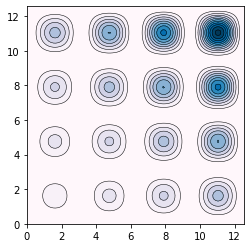

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# parameters of the SearchSpace
class SearchSpace:
    dim = 2

    # fitness function parameters
    w = 1
    # this controls how many peaks you want in the search space
    num_peaks_sqrt =  4     #@param {type : 'integer'}
    sigma = 10 + 2.5*(num_peaks_sqrt - 4)

    num_peaks = num_peaks_sqrt**2
    n_per_peak = 25
    with_moat = False

    # search space parameters
    start = 0
    stop = num_peaks_sqrt*np.pi
    N = num_peaks_sqrt * n_per_peak
    
    f_normal = lambda x,y : np.power(np.sin(SearchSpace.w*x) * np.sin(SearchSpace.w*y),2) * np.exp((x+y)/SearchSpace.sigma)

    @classmethod
    def f_moat(cls, xv,yv):  
        ''' Alternate fitness function with a "moat". '''  
        if xv.shape != yv.shape:
            print("Warning! Different shapes of x and y.")

        s = cls.stop
        nps = cls.num_peaks_sqrt
        z = np.empty(xv.shape, dtype = float)
        if (len(xv.shape) < 2):
            nx = xv.shape[0]
            for i in range(nx):
                x,y = xv[i], yv[i]
                z[i] = cls.f_normal(x,y) if ((x < s/nps) or (y < s/nps) or ((x > (1-1/nps)*s) and (y > (1-1/nps)*s))) else 0
        else:
            ny,nx = xv.shape
            for i in range(nx):
                for j in range(ny):
                    x,y = xv[i,j], yv[i,j]
                    z[i,j] = cls.f_normal(x,y) if ((x < s/nps) or (y < s/nps) or ((x > (1-1/nps)*s) and (y > (1-1/nps)*s))) else 0
        
        return z
    
    @classmethod
    def plot2d(cls, ax):
        ''' Plot 2d search space. '''
        # making the hill
        x = np.linspace(SearchSpace.start, SearchSpace.stop, num=SearchSpace.N)
        xv, yv = np.meshgrid(x, x)
        f = cls.f_moat if cls.with_moat else cls.f_normal
        z = f(xv,yv) # (np.sin(w*x)**2) * (np.sin(w*y)**2) * np.exp((x+y)/sigma)
        _ = ax.contour(x.reshape(-1), x.reshape(-1), z, levels=12, linewidths=0.5, colors='k', extend='both')
        _ = ax.contourf(x.reshape(-1), x.reshape(-1), z, levels=12, cmap='PuBu', extend='both')

        pass
    
SearchSpace.with_moat = False #@param {type:"boolean"}

fig, ax = plt.subplots()
ax.set_aspect('equal')
SearchSpace.plot2d(ax)
fig.show()


## Chromosome

In [0]:
class Chromosome:
    num_genes = SearchSpace.dim
    genes_lower_bound = SearchSpace.start * np.ones(num_genes)
    genes_upper_bound = SearchSpace.stop * np.ones(num_genes)
    p_mutation = 0.1
    p_crossover = 0.75
    mutation_step = 3
    hash_precision = 4
    
    @classmethod
    def plot(cls, c, ax):
        ''' Plot first 2 genes of a chromosome as xy coordinates. '''
        ax.plot(c[0], c[1], 'ko', ms=3)
    
    @classmethod
    def prehash(cls, c):
        ''' Make a string from chromosome that can be used for hashing. '''
        c = np.around(10**Chromosome.hash_precision*c, decimals=0)
        s = ""
        for g in c[:Chromosome.num_genes]:
            s += str(g)[:-2]
        return s



## Defining the population and genetic operators

In [0]:
class Population:
    default_cap = 100
    start = SearchSpace.start
    stop = SearchSpace.stop/SearchSpace.num_peaks_sqrt
    p_selection_in_tournament = 0
    
    # new random population
    def __init__(self, cap=None):
        if cap is None:
            cap = Population.default_cap
            
        self.cap = cap
        self.max_size = 2*cap**2
        self.default_tournament_size = cap
        
        self.hash = set()
        self.gen = np.empty((self.max_size, Chromosome.num_genes+1), dtype=float)
        self.last = 0
        while self.last < self.cap:
            self.add(Population.start+(Population.stop - Population.start)*np.random.rand(Chromosome.num_genes))
        
    def size(self):
        return self.last
    
    def __len__(self):
        return self.last
    
    def add(self, c):
        if self.last == self.max_size:
            print("ERROR. Adding to a full generation matrix")
            return
        if (c[0] < Population.start) or (c[1] < Population.start):
            print("SOMETHING IS VERY WRONG")

        s = Chromosome.prehash(c)
        if not s in self.hash:
            self.gen[self.last, :Chromosome.num_genes] = c
            self.last += 1
            self.hash.add(s)
        
    def __str__(self):
        s = ""
        for c in self.gen:
            s += str(c) + '\n'
        return s
            
    def plot(self, ax):
        for c in self.gen[:self.last, :2]:
            Chromosome.plot(c, ax)
        pass

    # monogenic mutation
    def mutate(self):
        old_size = self.size()
        
        for i in range(old_size):
            if np.random.rand() < Chromosome.p_mutation:
                c = np.copy(self.gen[i,:Chromosome.num_genes])
                gene_idx = np.random.randint(0, Chromosome.num_genes)
                # step = (2*np.random.rand()-1)*Chromosome.mutation_step
                step = np.sign(np.random.rand() - 0.5)*np.random.rand()*Chromosome.mutation_step
                c[gene_idx] += step
                if c[gene_idx] < SearchSpace.start:
                    c[gene_idx] -= 2*step
                if c[gene_idx] > SearchSpace.stop:
                    c[gene_idx] -= 2*step
                self.add(c)

    def crossover(self):
        old_size = self.last
        for i in range(old_size):
            for j in range(i+1, old_size):
                if (np.random.rand() < Chromosome.p_crossover):
                    c_idx = np.random.randint(1,Chromosome.num_genes)
                    c1 = np.copy(self.gen[i,:Chromosome.num_genes])
                    c1[c_idx:] = self.gen[j,c_idx:Chromosome.num_genes]
                    c2 = np.copy(self.gen[j,:Chromosome.num_genes])
                    c2[c_idx:] = self.gen[i,c_idx:Chromosome.num_genes]

                    self.add(c1)
                    self.add(c2)
    
    def calc_fitness(self):
        fitness = SearchSpace.f_moat if SearchSpace.with_moat else SearchSpace.f_normal
        self.gen[:self.last, 2] = fitness(self.gen[:self.last, 0], self.gen[:self.last,1])

    def sort(self):
        # fitness based sort
        idx = self.gen[:self.last, 2].argsort()[::-1]
        self.gen[:self.last] = self.gen[idx]

    def preselect(self):
        self.calc_fitness()
        self.sort()

    def truncate(self, start=None):
        ''' Simple truncation '''
        if start is None:
            start = self.cap
        if start != self.cap:
            print("Warning! Number of selected chromosomes is different from popcap.")
            return
        # remove elements from hashset
        for c in self.gen[start:self.last, :Chromosome.num_genes]:
            s = Chromosome.prehash(c)
            self.hash.remove(s)
        # move buffer tail to popcap
        self.last = self.cap
    
    # TODO expand docstring
    def rearange(self, mask):
        ''' Rearange the chromosomes in generation matrix according to mask such that:
        the first part of the generation matrix contains chromosomes with values True in the mask,
        and the second part contains the ones with the values False.'''
        N = np.count_nonzero(mask)
        
        if N != self.cap:
            print("Warning! Number of selected chromosomes is different from popcap.")
        
        aux_mask = np.zeros(self.max_size, dtype=bool)
        aux_mask[:self.last] = True

        self.gen[:N], self.gen[N:self.last] = self.gen[mask], self.gen[mask!=aux_mask]
        return N
    
    def keep(self, mask):
        ''' Given a boolean mask that represents which chromosomes to keep,
        first rearange the generation matrix and then truncate the leftover chromosomes. '''
        N = self.rearange(mask)
        self.truncate(N)
    
    def truncation_select(self):
        ''' Keeps the individuals with best fitness. '''
        if self.size() > self.cap:
            self.preselect()
            self.truncate()
        
    def fps_select(self):
        ''' Fitness Proportionate Selection, aka "Roulette wheel" selection. '''
        if self.size() > self.cap:
            self.preselect()

            f = np.copy(self.gen[:self.last, Chromosome.num_genes]) # first column after chromosome values is fitness
            f = f / np.sum(f)
            for i in range(1,self.last):
                f[i] += f[i-1]

            mask = np.zeros(self.max_size, dtype=bool)
            n_selected = 0
            while n_selected != self.cap:
                rnd = np.random.rand()
                idx = np.searchsorted(f, rnd) # binary search
                if not mask[idx]:
                    mask[idx] = True
                    n_selected += 1
            self.keep(mask)
    
    def sus_select(self):
        ''' Stoachastic Universal Sampling method. '''
        if self.size() > self.cap:
            self.preselect()

            f = np.copy(self.gen[:self.last, Chromosome.num_genes]) # first column after chromosome values is fitness
            F = np.sum(f) # should be 1
            N = self.cap
            P = F/N
            mask = np.zeros(self.max_size, dtype=bool)
            
            Start = P*np.random.rand()
            Pointers = Start + P*np.arange(N)

            # cumulative sum
            # f = f / F
            for i in range(1,self.last):
                f[i] += f[i-1]

            i = 0
            for P in Pointers:
                while (f[i] < P) and (self.last != i):
                    i += 1
                if not mask[i]:
                    mask[i] = True
                else:
                    # edge case where the collision happens
                    # pick a side randomly
                    if np.random.rand() < 0.5:
                        # go forward:
                        for j in range(i+1, i+N):
                            k = j % N
                            if not mask[k]:
                                mask[k] = True   
                    else:
                        # or, go back
                        for j in range(i-1, i-N, -1):
                            k = j % N
                            if not mask[k]:
                                mask[k] = True          
            self.keep(mask)          

    def tournament_select(self, tsize=None):
        ''' Tournament selection. '''
        if self.size() > self.cap:
            self.preselect()
            mask = np.zeros(self.max_size, dtype=bool)

            if tsize is None:
                tsize = self.default_tournament_size

            n_selected = 0
            while n_selected < self.cap:
                tournament = np.sort(np.random.choice(self.last, tsize))
                for idx in tournament:
                    if (np.random.rand() < Population.p_selection_in_tournament) and (not mask[idx]):
                        mask[idx] = True
                        n_selected += 1
                        break                        
            self.keep(mask)

    def select(self, type='tournament'):
        ''' Perform a selection of given type. '''
        function = {'trunc':self.truncation_select,
                    'fps':self.fps_select,
                    'sus':self.sus_select,
                    'tournament':self.tournament_select,
                    }
        
        function[type]()
            
    def max(self):
        ''' Return maximum fitness of current generation and its chromosome. '''
        idx = np.argmax(self.gen[:self.last, Chromosome.num_genes])
        f = self.gen[idx, Chromosome.num_genes]
        c = self.gen[idx, :Chromosome.num_genes]
        return f, c


## Functions for running the simulation

In [0]:
def run_ga(p, num, selection):
    ''' Run GA on population p, for num generations, with given selection type. '''
    max_fitness = np.zeros(num, dtype=float)
    max_chromosome = np.zeros((num, Chromosome.num_genes), dtype=float)
    for i in range(num):
        p.crossover()
        # print('        size after crossover: ', p.size())
        p.mutate()
        # print('            size after mutation: ', p.size())
        p.select(selection)
        # print('                size after selection: ', p.size())
        max_fitness[i], max_chromosome[i] = p.max()
        # print("Generation", i," max fitness =", max_fitness[i])
    return max_fitness, max_chromosome

def plot_ga(p, max_fitness, max_chromosome, num, selection):
    ''' On a new figure, plot the (assumably last) generation and the max fitness per generation curve. '''
    fig = plt.figure()
    ax = plt.subplot(1, 2, 1)
    ax.set_aspect('equal')
    SearchSpace.plot2d(ax)
    p.plot(ax)
    plt.title(selection+", "+str(num)+" generacija")
    
    ax = plt.subplot(1, 2, 2)
    ax.plot(np.arange(num), max_fitness)
    plt.xlabel("#generacija")
    plt.title("max fitness")

def run_and_plot(p, num, selection):
    ''' Run and plot GA. '''
    max_fitness, max_chromosome = run_ga(p, num, selection)
    plot_ga(p, max_fitness, max_chromosome, num, selection)

    return max_fitness, max_chromosome


## Running the simulation

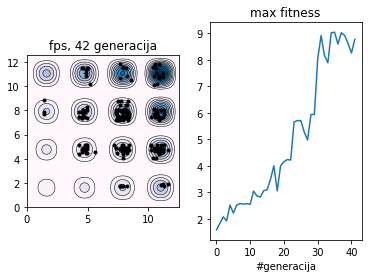

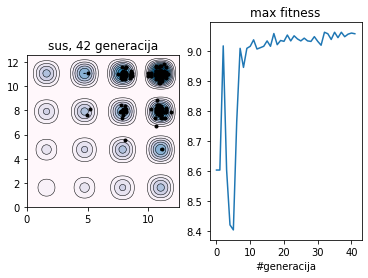

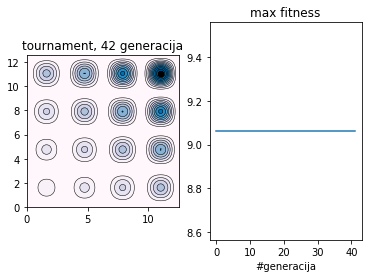

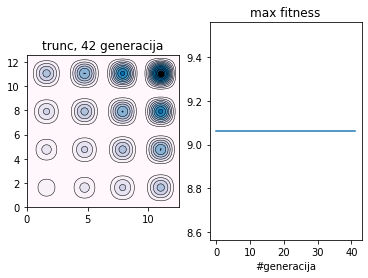

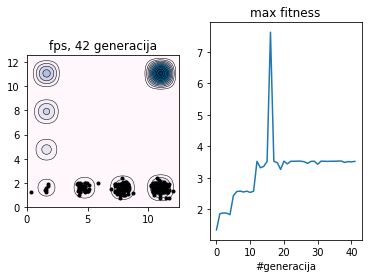

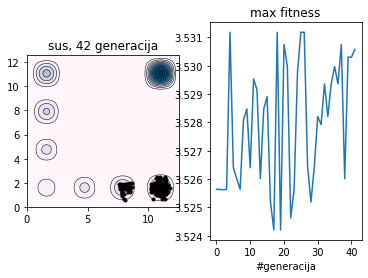

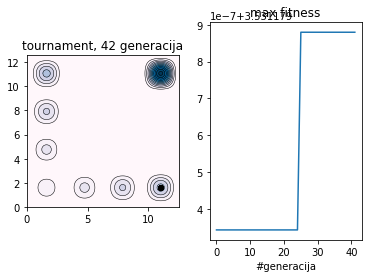

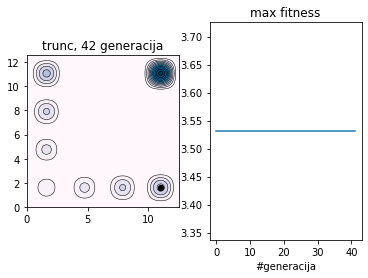

In [0]:
# GA parameters:
Chromosome.p_mutation = 0.1   #@param {type:'number'}
Chromosome.p_crossover = 0.75     #@param {type:'number'}
Chromosome.mutation_step = 3.15 #@param {type:'number'}
Population.p_selection_in_tournament = 0.667 #@param {type: 'number'}
num_generations =  42#@param {type: 'integer'}
popcap = 200 #@param {type: 'integer'}
S = ['fps', 'sus', 'tournament', 'trunc'] # use all selection algorithms

# one round of simulations without the "moat"
SearchSpace.with_moat = False #param {type:"boolean"}
p = Population(popcap)
for selection in S:
    max_fitness, max_chromosome = run_and_plot(p, num_generations, selection)

# one round of simulations with the "moat"
SearchSpace.with_moat = True
p = Population(popcap)
for selection in ['fps', 'sus', 'tournament', 'trunc']:
    max_fitness, max_chromosome = run_and_plot(p, num_generations, selection)
